In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.impute import *

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from pandas.plotting import autocorrelation_plot

In [2]:
df = pd.read_csv("data60.csv", low_memory=False)
# replace ? for NAN
df = df.replace('?', np.nan)
# Delete rows with missing values
df = df.dropna()
df = df.astype(float)

target_columns = df.iloc[:,-33:].columns
y = df.loc[:, target_columns].astype(float).sum(axis=1)
df.drop(columns=target_columns, inplace=True)

df["ut_ms"] = [datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d, %H:%M:%S') for x in df["ut_ms"]]
df["ut_ms"] = pd.to_datetime(df["ut_ms"])

In [6]:
data = pd.DataFrame({
    "date" : df["ut_ms"].iloc[:20000],
    "target" : y.loc[:20000]
})
data = data.dropna()

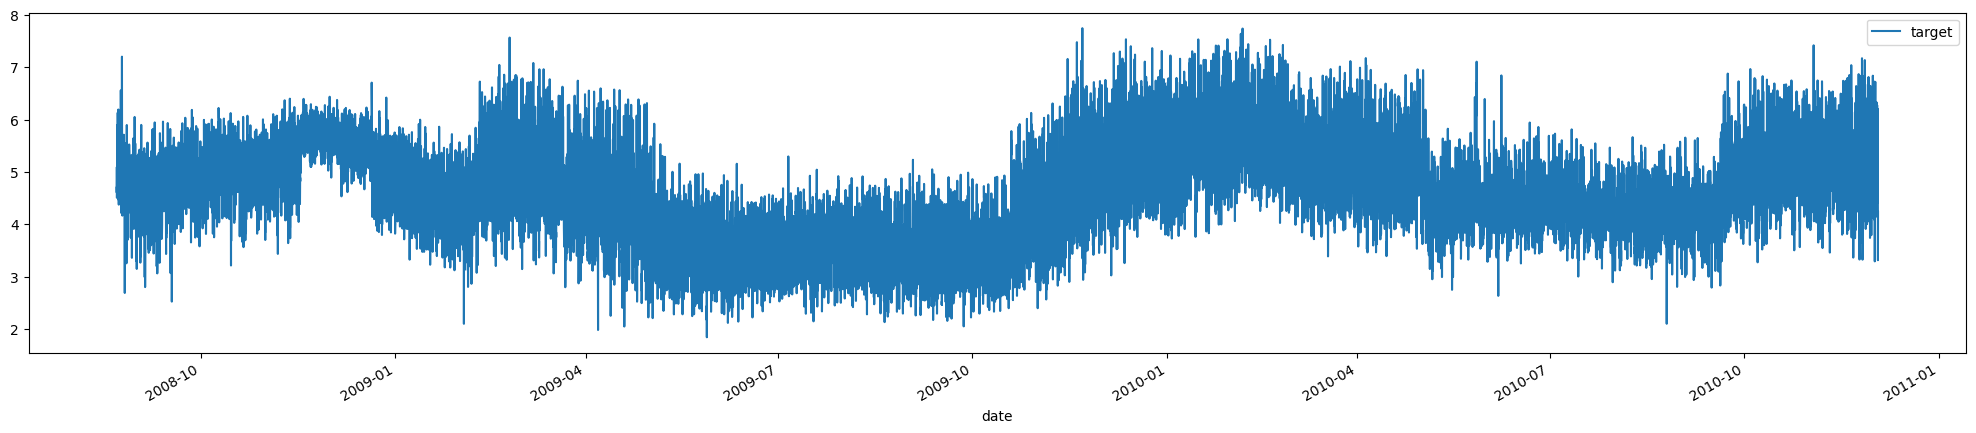

In [7]:
data.set_index("date", inplace=True) #setting "Date" as ind

#dara = data.asfreq("b").copy() #setting frequency to business days

data['target'] = data['target'].fillna(method="ffill") #forward filling missing values (due to holidays in India)

data.plot(figsize=(25,5))
plt.show()

In [8]:
def my_auto_corr(df, nlags=2):
    '''
    Returns autocorrelation coefficient for lags [nlags, 0]
    
    df: dataframe
        Input dataframe of time series
    nlags: int
           maximum number of lags, default 2
    
    Returns
    array: autocorrelation coefficients for lags [nlags, 0]
    '''
    def autocorr(y, lag=2):
        '''
        Calculates autocorrelation coefficient for single lag value
        
        y: array
           Input time series array
        lag: int, default: 2 
             'kth' lag value
        
        Returns
        int: autocorrelation coefficient 
        '''
        y = np.array(y).copy()
        y_bar = np.mean(y) #y_bar = mean of the time series y
        denominator = sum((y - y_bar) ** 2) #sum of squared differences between y(t) and y_bar
        numerator_p1 = y[lag:] - y_bar #y(t)-y_bar: difference between time series (from 'lag' till the end) and y_bar
        numerator_p2 = y[:-lag] - y_bar #y(t-k)-y_bar: difference between time series (from the start till lag) and y_bar
        numerator = sum(numerator_p1 * numerator_p2) #sum of y(t)-y_bar and y(t-k)-y_bar
        return (numerator / denominator)
    
    acf = [1] #initializing list with autocorrelation coefficient for lag k=0 which is always 1
    for i in range(1, (nlags + 1)):
        acf.append(autocorr(df.iloc[:, 0].values, lag=i)) #calling autocorr function for each lag 'i'
    return np.array(acf)

In [11]:
from statsmodels.graphics import tsaplots
print(f'my_auto_corr:\n{my_auto_corr(df=data, nlags=10)}\n\nstatsmodels acf:\n{tsaplots.acf(data.iloc[:,0].values,nlags=10)}')


my_auto_corr:
[1.         0.71683234 0.61666559 0.54573471 0.50629412 0.52441323
 0.55016821 0.65033876 0.52163137 0.5086029  0.48465674]

statsmodels acf:
[1.         0.71683234 0.61666559 0.54573471 0.50629412 0.52441323
 0.55016821 0.65033876 0.52163137 0.5086029  0.48465674]
